In [ ]:
from __future__ import print_function

#Numpy, pandas ans os
import numpy as np
import pandas as pd
import os
# matplotlib for displaying the output
import matplotlib.pyplot as plt

# Librosa for audio
import librosa

#librairies for classification
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, make_scorer, confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV
import joblib
#for warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category= ConvergenceWarning)

warnings.filterwarnings("ignore", category= UserWarning)
warnings.filterwarnings("ignore", category= RuntimeWarning)

Dataframe to match audio with emotion

In [ ]:
import pandas as pd
import os
parent_dir = "audio_emotion"
def prepare_datadf(parent_dir): # a function whose parameter is the audio folder
    df = pd.DataFrame(columns = ['audio', 'label']) #dataframe columns
    
    for  fichier_audio in os.listdir(parent_dir): # for each element in the audio folder
        folder_path = os.path.join(parent_dir, fichier_audio) # path of each item  in the audio folder
        
       
        
        if(os.path.isdir(folder_path)): 
            audios = os.listdir(folder_path) #content of each emotional file
            for i in audios:
                emotion = None
                if i.endswith('outNoise.wav'):
                    if i[7] == '5':
                        emotion = 1
                    
                    else:
                        emotion = 0
                    df = df.append(pd.DataFrame({'audio':[os.path.join(fichier_audio, i)], 'label':[emotion]}), 
                           ignore_index=True) # here at df defined, with the columns we add the values:
                                            #the audio column will take the audios_path, 
                                            #and the emotion column will take the corresponding emotion, ie the name of the folder
    #Shuffling for randomness
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df
datadf = prepare_datadf(parent_dir) #function call
display(datadf.head()) #dataframe display

	

,audio,label
0,disgust/03-01-07-01-01-02-18_norm_outNoise.wav,0
1,sad/03-01-04-01-02-01-09_norm_outNoise.wav,0
2,angry/03-01-05-01-02-02-17_norm_outNoise.wav,1
3,happy/03-01-03-01-01-01-15_norm_outNoise.wav,0
4,surprised/03-01-08-01-02-02-07_norm_outNoise.wav,0


In [ ]:
array=datadf.values
audios=array[:,0]
emotions=array[:,1]
print(datadf.label.value_counts())

0    1053
1     192
Name: label, dtype: int64


Features extraction

In [ ]:
import numpy as np
import librosa
def get_all_features(audio_file):
 
  x, sample_rate = librosa.load(audio_file)
  ## Numpy array that will store all the features
  result=np.array([])
        
        ## MFCCs
  mfccs=np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis=0)
  result=np.hstack((result, mfccs))

          ## Mel Scale
  mel=np.mean(librosa.feature.melspectrogram(x, sr=sample_rate).T,axis=0)
  result=np.hstack((result, mel))

        
        ## Chroma
  stft=np.abs(librosa.stft(x))
  chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  result=np.hstack((result, chroma))
        
 
        ##contrast
  contrast=np.mean(librosa.feature.spectral_contrast( S = stft, sr=sample_rate).T,axis=0)
  result=np.hstack((result, contrast))

## tonnetz
  y = librosa.effects.harmonic(x)
  tonnetz=np.mean(librosa.feature.tonnetz(y, sr=sample_rate).T,axis=0)
  result=np.hstack((result,  tonnetz))

    
  return result

Application of features extraction function on all audios

In [ ]:
all_features = []
folder ='audio_emotion'
for audio_file in array[:,0]:
    if audio_file.endswith('.wav'):
        
        features = get_all_features(folder+'/'+audio_file)
        all_features.append(features)

In [ ]:
print(len(all_features))

1245


Encode labels

In [ ]:
encod = preprocessing.LabelEncoder()
emotions = array[:,1]
encod.fit(emotions)
list(encod.classes_)
labels=encod.transform(emotions)

Scale features

In [ ]:
scaler = StandardScaler()
scaler.fit(all_features)
X_scaler = scaler.transform(all_features)

Oversampling

In [ ]:
ada = ADASYN(sampling_strategy = 0.6)
X, y = ada.fit_sample(X_scaler, labels.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

After OverSampling, counts of label '1': 649
After OverSampling, counts of label '0': 1053


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Split dataset to Train, Test and Val

In [23]:
#split train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

print(len(X_train))
print(len(X_test))
print(len(X_val))

1088
341
273


Reshape Labels and features for deep learning model

In [24]:
import os
from glob import glob
import pickle
import numpy as np

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

Features

In [25]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

In [26]:
 X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
 X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

 print(X_train.shape)
 print(X_test.shape)
 print(X_val.shape)

(1088, 193, 1)
(341, 193, 1)
(273, 193, 1)


labels

In [27]:

from keras.utils import to_categorical

# Encode the classification labels
le = LabelEncoder()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


(1088, 2)
(341, 2)
(273, 2)


### Classification 

Model

In [28]:
input_y = Input(shape= (193,1))

In [29]:
## First LFLB (local feature learning block)
y = Conv1D(256, kernel_size=5, strides= 1,  name='Conv_1', padding = 'same')(input_y)
y = BatchNormalization( name='BatchNorm_1')(y)
y = Activation('elu', name='Activ_1')(y)

y = Conv1D(128, kernel_size=5, strides= 1,  name='Conv_2', padding = 'same')(input_y)
y = Activation('elu', name='Activ_2')(y)

y = Dropout(0.2, name='Drop_1')(y)
y = BatchNormalization( name='BatchNorm_2')(y)
y = MaxPooling1D(pool_size=8, name = 'maxpooling', padding = 'same') (y) 

y = Conv1D(128, kernel_size= 5, strides= 1,  name='Conv_3', padding = 'same')(y)
y = Activation('elu', name='Activ_3')(y)

y = Conv1D(128, kernel_size= 5, strides= 1,  name='Conv_4', padding = 'same')(y)
y = Activation('elu', name='Activ_4')(y)

y = Conv1D(128, kernel_size=5, strides= 1,  name='Conv_5', padding = 'same')(input_y)
y = BatchNormalization( name='BatchNorm_3')(y)
y = Activation('elu', name='Activ_5')(y)

y = Dropout(0.2, name='Drop_2')(y)     

y = Conv1D(128, kernel_size= 5, strides= 1,  name='Conv_6', padding = 'same')(y)

y = Flatten(name='Flat')(y)
y = Dropout(0.2, name='Drop_3')(y)  

y = Dense(y_train.shape[1],  name='dense')(y)

y = BatchNormalization(name='BatchNorm_4')(y)

y = Activation('softmax', name='Activ_6')(y)









# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 193, 1)]          0         
_________________________________________________________________
Conv_5 (Conv1D)              (None, 193, 128)          768       
_________________________________________________________________
BatchNorm_3 (BatchNormalizat (None, 193, 128)          512       
_________________________________________________________________
Activ_5 (Activation)         (None, 193, 128)          0         
_________________________________________________________________
Drop_2 (Dropout)             (None, 193, 128)          0         
_________________________________________________________________
Conv_6 (Conv1D)              (None, 193, 128)          82048     
_________________________________________________________________
Flat (Flatten)               (None, 24704)            

In [30]:
from tensorflow import keras
METRICS = [
      
      keras.metrics.BinaryAccuracy(name='accuracy'),
      
      keras.metrics.AUC(name='auc'),
]


In [31]:
# Compile model
model.compile(optimizer=RMSprop(lr=0.00001, decay=1e-6), loss='categorical_crossentropy', metrics=[METRICS])

# Save best model
best_model_save = ModelCheckpoint('angry_other_features.hdf5', save_best_only=True, monitor='val_loss', mode='auto')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 30,  verbose=1, mode='auto')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=700, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/700
17/17 [==============================] - 1s 35ms/step - loss: 0.8714 - accuracy: 0.4789 - auc: 0.4897 - val_loss: 0.6812 - val_accuracy: 0.5249 - val_auc: 0.5862
Epoch 2/700
17/17 [==============================] - 0s 12ms/step - loss: 0.6796 - accuracy: 0.6094 - auc: 0.6566 - val_loss: 0.6645 - val_accuracy: 0.5806 - val_auc: 0.6534
Epoch 3/700
17/17 [==============================] - 0s 11ms/step - loss: 0.6075 - accuracy: 0.6728 - auc: 0.7328 - val_loss: 0.6518 - val_accuracy: 0.6276 - val_auc: 0.6927
Epoch 4/700
17/17 [==============================] - 0s 12ms/step - loss: 0.5597 - accuracy: 0.7132 - auc: 0.7827 - val_loss: 0.6415 - val_accuracy: 0.6276 - val_auc: 0.7139
Epoch 5/700
17/17 [==============================] - 0s 11ms/step - loss: 0.5157 - accuracy: 0.7748 - auc: 0.8304 - val_loss: 0.6342 - val_accuracy: 0.6364 - val_auc: 0.7216
Epoch 6/700
17/17 [==============================] - 0s 11ms/step - loss: 0.4891 - accuracy: 0.7803 - auc: 0.8512 - val_loss: 0.62

In [32]:
from tensorflow.keras.models import load_model
model = load_model('angry_other_features.hdf5')


In [33]:

test_predictions_baseline = model.predict(X_test)


In [34]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(True Negatives): ', cm[0][0])
  print('(False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print('(True Positives): ', cm[1][1])
  print('Total emotions_happy: ', np.sum(cm[1]))


loss :  0.3505951762199402
accuracy :  0.8563050031661987
auc :  0.9329297542572021

(True Negatives):  176
(False Positives):  43
(False Negatives):  6
(True Positives):  116
Total emotions_happy:  122
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       219
           1       0.73      0.95      0.83       122

    accuracy                           0.86       341
   macro avg       0.85      0.88      0.85       341
weighted avg       0.88      0.86      0.86       341



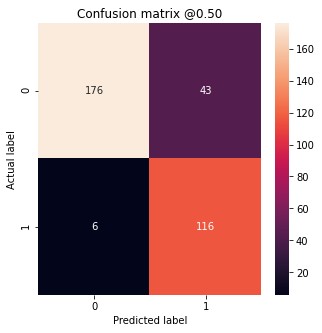

In [36]:
import seaborn as sns 
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size= 64, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_pred = np.argmax(test_predictions_baseline, axis= 1)
yy_test = np.argmax(y_test, axis  = 1)
plot_cm(yy_test, y_pred)

print(classification_report(yy_test, y_pred))



Validation

In [37]:

val_predictions_baseline = model.predict(X_val)


loss :  0.3232819139957428
accuracy :  0.8827838897705078
auc :  0.9454172849655151

(True Negatives):  133
(False Positives):  31
(False Negatives):  1
(True Positives):  108
Total emotions_happy:  109
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       164
           1       0.78      0.99      0.87       109

    accuracy                           0.88       273
   macro avg       0.88      0.90      0.88       273
weighted avg       0.91      0.88      0.88       273



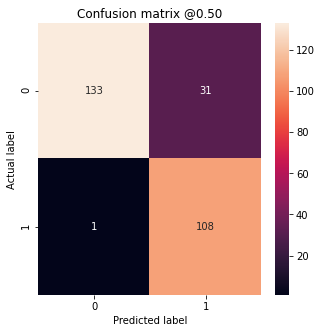

In [38]:
import seaborn as sns 
baseline_results = model.evaluate(X_val, y_val,
                                  batch_size= 64, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_pred_val = np.argmax(val_predictions_baseline, axis= 1)
yy_val = np.argmax(y_val, axis  = 1)
plot_cm(yy_val, y_pred_val)

print(classification_report(yy_val, y_pred_val))

